<a href="https://colab.research.google.com/github/fansari100/Heston/blob/main/master_erp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ────────────────────────────────────────────────────────────────────────────
# 0. One‑time installs (exact versions for deterministic output)
# ────────────────────────────────────────────────────────────────────────────
!pip -q install python-docx==1.1.0 plotly==5.24.1 kaleido==0.2.1 yfinance==0.* \
                 bs4 lxml pandas numpy pandas_datareader docx2pdf==0.1.8

In [ ]:
!pip -q uninstall kaleido plotly

Proceed (Y/n)? Y
Proceed (Y/n)? Y


In [6]:
!pip -q install python-docx==1.1.0 plotly==5.24.1 kaleido==0.2.1 yfinance==0.* \
                bs4 lxml pandas numpy pandas data_reader docx2pdf==0.1.8

In [7]:
import yfinance as yf

dji_ticker = yf.Ticker("^DJI")
dji_df = dji_ticker.history(period="max")
dji_df.reset_index(inplace=True)
dji_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1992-01-02 00:00:00-05:00,3152.100098,3172.629883,3139.310059,3172.399902,23550000,0.0,0.0
1,1992-01-03 00:00:00-05:00,3172.399902,3210.639893,3165.919922,3201.500000,23620000,0.0,0.0
2,1992-01-06 00:00:00-05:00,3201.500000,3213.330078,3191.860107,3200.100098,27280000,0.0,0.0
3,1992-01-07 00:00:00-05:00,3200.100098,3210.199951,3184.479980,3204.800049,25510000,0.0,0.0
4,1992-01-08 00:00:00-05:00,3204.800049,3229.199951,3185.820068,3203.899902,29040000,0.0,0.0


In [8]:
sp500_ticker = yf.Ticker("^GSPC")
sp500_df = sp500_ticker.history(period="max")
sp500_df.reset_index(inplace=True)
sp500_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1,1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
2,1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
3,1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
4,1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [9]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from pathlib import Path
from docx import Document
from docx.shared import Inches

In [10]:
doc1_master_test = Document()
doc1_master_test.save("doc1 master test.docx")

In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# 0. IMPORTS & GLOBAL CONFIG
# ─────────────────────────────────────────────────────────────────────────────
import datetime as dt, re, requests, yfinance as yf, pandas as pd, numpy as np
from bs4 import BeautifulSoup
from pathlib import Path
from pandas_datareader import data as pdr          # for 20‑Year UST if needed

from docx import Document
from docx.shared import Inches, Pt, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml import OxmlElement, parse_xml
from docx.oxml.ns import qn

# Word‑wide styling
FONT_FACE, FONT_SIZE = "Sabon LT Std", 11
LEFT_RIGHT, TOP_BOTTOM = Inches(1.0), Inches(1.0)

OUT_DIR = Path("_plots"); OUT_DIR.mkdir(exist_ok=True)      # where charts live

# ─────────────────────────────────────────────────────────────────────────────
# 1. NEW DOCUMENT + PAGE SETUP
# ─────────────────────────────────────────────────────────────────────────────
sec = doc1_master_test.sections[0]
sec.left_margin  = LEFT_RIGHT
sec.right_margin = LEFT_RIGHT
sec.top_margin   = TOP_BOTTOM
sec.bottom_margin= TOP_BOTTOM # Corrected typo here

# default font
style = doc1_master_test.styles["Normal"]
style.font.name = FONT_FACE
style._element.rPr.rFonts.set(qn("w:eastAsia"), FONT_FACE)
style.font.size = Pt(FONT_SIZE)

# ─────────────────────────────────────────────────────────────────────────────
# 2. HEADER (all pages) — left text + right‑aligned page # + date below
# ─────────────────────────────────────────────────────────────────────────────
# Use timezone-aware approach to get today's date
USE_LOCAL_TZ = True # Ensure this is True if you want local time
today = dt.datetime.now().astimezone() if USE_LOCAL_TZ else dt.datetime.utcnow()
today_str = today.strftime("%B %-d, %Y")

EMU_PER_TWIP = 635  # 1 twip = 635 EMU

for section in doc1_master_test.sections:
    header = section.header
    # Clear any existing content
    for p in header.paragraphs:
        p._element.getparent().remove(p._element)

    # Line‑1: committee (left)  +  PAGE # (right)
    p1 = header.add_paragraph()
    # Add right‑aligned tab stop at usable width
    usable_emu = section.page_width - section.left_margin - section.right_margin
    pos_twips  = int(usable_emu / EMU_PER_TWIP)
    pPr = p1._p.get_or_add_pPr()
    tabs = OxmlElement("w:tabs"); pPr.append(tabs)
    tab  = OxmlElement("w:tab")
    tab.set(qn("w:val"), "right")
    tab.set(qn("w:pos"), str(pos_twips))
    tabs.append(tab)

    p1.add_run("Technical Standards Committee")
    p1.add_run().add_tab()  # jump to right tab stop
    run = p1.add_run()
    fld_begin = OxmlElement("w:fldChar"); fld_begin.set(qn("w:fldCharType"), "begin")
    instr     = OxmlElement("w:instrText"); instr.text = " PAGE "
    fld_end   = OxmlElement("w:fldChar");   fld_end.set(qn("w:fldCharType"), "end")
    run._r.extend([fld_begin, instr, fld_end])

    # Line‑2: date
    header.add_paragraph(today_str)

# ─────────────────────────────────────────────────────────────────────────────
# 3. FIRST‑PAGE‑ONLY FOOTER (7‑pt font, centred)
# ─────────────────────────────────────────────────────────────────────────────
sec.different_first_page_header_footer = True
footer = sec.first_page_footer

def footer_line(text):
    p = footer.add_paragraph(text)
    p.alignment = WD_ALIGN_PARAGRAPH.CENTER
    for r in p.runs:
        r.font.size = Pt(7)

footer_line("10250 Constellation Boulevard, 5th Floor • Los Angeles, California 90067 "
            "• tel.310.553.8871 • fax.310.553.2173 • www.HL.com")
footer_line("Broker/dealer services through Houlihan Lokey Capital, Inc.")

# ─────────────────────────────────────────────────────────────────────────────
# 4. BODY — PAGE 1
# ─────────────────────────────────────────────────────────────────────────────
heading = doc1_master_test.add_heading("Houlihan Lokey", level=0)
heading.alignment = WD_ALIGN_PARAGRAPH.CENTER
run = heading.runs[0]
run.font.name = "Arial"
run.bold = True
# Attempt to set font color to blue using XML
rPr = run._r.get_or_add_rPr()
color = OxmlElement('w:color')
color.set(qn('w:val'), '002147') # Hex code for blue
rPr.append(color)

doc1_master_test.add_paragraph()  # spacing

p_to = doc1_master_test.add_paragraph()
p_to.add_run("To").bold = True
p_to.add_run(": Technical Standards Committee (“TSC”)")

p_from = doc1_master_test.add_paragraph()
p_from.add_run("From").bold = True
p_from.add_run(": Terence Tchen, Elaine Pan, Abigale Lischak")

p_date = doc1_master_test.add_paragraph()
p_date.add_run("Date").bold = True
p_date.add_run(f": {today_str}")

p_subject = doc1_master_test.add_paragraph()
p_subject.add_run("Subject").bold = True
p_subject.add_run(": Equity Risk Premium – July 2025 Update")


disclaimer = (
    "The purpose of this memorandum is to provide general guidance to the financial staff "
    "regarding the valuation practice of Houlihan Lokey. To that end, this memorandum "
    "sets forth the procedures and standards applicable to typical or common business "
    "situations in which valuations are performed. Situations may arise, however, in which "
    "none of the procedures outlined herein are applicable, or the procedures should be "
    "modified in some way, or some procedures outlined here should be employed and others not."
)

disclaimer2 = (
    "While it is Houlihan Lokey's policy that all financial staff members generally adhere to the "
    "policies and standards reflected in these memoranda, it must also be recognized that the ultimate "
    "standard is the exercise of sound professional judgment consistent with the specific facts and "
    "circumstances of the business or asset being valued."
)

disclaimer3 = (
    "Thus, these memoranda contain recommended procedures and forms that should be employed in many situations. "
    "However, these memoranda are not a substitute for good judgment, as certain procedures, even if generally "
    "recommended may not be appropriate in certain situations, and some situations may be encountered in which "
    "methods other than those presented here should be used. In every case, the specific facts should determine "
    "the methods and procedures employed."
)

disclaimer4 = (
    "This memorandum may contain time-sensitive material. Consequently, this should be considered when utilizing "
    "the information contained in the memorandum."
)

disclaimer5 = (
    "This memorandum may contain legal and tax information. If so, this information is set forth merely to provide "
    "a background for various issues. The memorandum should not be considered a substitute for legal and tax expertise."
)

# Add and format the disclaimer paragraphs
disclaimer_paragraphs = [
    doc1_master_test.add_paragraph(disclaimer),
    doc1_master_test.add_paragraph(disclaimer2),
    doc1_master_test.add_paragraph(disclaimer3),
    doc1_master_test.add_paragraph(disclaimer4),
    doc1_master_test.add_paragraph(disclaimer5)
]

for para in disclaimer_paragraphs:
    for run in para.runs:
        run.font.italic = True
        run.font.size = Pt(7)


intro_heading = "Introduction and Background"

#doc1_master_test.add_paragraph(intro_heading).bold = True
p_intro = doc1_master_test.add_paragraph()
p_intro.add_run(intro_heading).bold = True

intro = (
    "The equity risk premium, or ERP, is one of the most important quantitative variables in "
    "securities valuation. ERP is an estimate of a market risk premium. That is, the amount "
    "of extra return that investors demand in order to invest in equity securities rather than "
    "U.gS. treasury securities. ERP is a forward looking concept. It is used to develop an estimate "
    "of the expected return of a risky security over some future period of time. As such, ERP is not "
    "observable in the marketplace. Consequently, valuation practitioners must develop ERP estimates "
    "based on observed historical returns or forward looking models of publicly traded equity securities."
)

doc1_master_test.add_paragraph(intro)

intro_2 = (
    "At the September 2007 TSC meeting, the TSC decided to abandon the then current practice of "
    "relying solely on the historical ERP published in Morningstar/Ibbotson's SBBI for our valuation "
    "templates. Instead, the TSC decided to follow the lead of many other valuation practitioners and "
    "adopt a Committee-determined ERP, based on a review of the valuation literature, periodically. "
    "Since adopting a Committee-determined ERP in September 2007, the TSC has met periodically to "
    "review ERP related market data. The purpose of this memo is to update the evidence considered "
    "by the TSC since its last meeting."
 )

doc1_master_test.add_paragraph(intro_2)

doc1_master_test.save("doc1 master test.docx")

In [12]:
doc1_master_test.add_page_break()

realized_returns = "Realized Returns (ex Post)"

p_returns = doc1_master_test.add_paragraph()
run = p_returns.add_run("Realized Returns ")
run.bold = True
run = p_returns.add_run("(ex Post)")
run.italic = True


p_historical_data = doc1_master_test.add_paragraph()
text_parts = [
    "Practitioners have traditionally relied heavily on historical data to estimate the ERP, most commonly using ",
    ("Cost of Capital Navigator", True),
    ", published by ",
    ("Kroll", True),
    ", as a source of historical stock price return data. However, practitioners are now looking beyond historical summary statistics as a sole source of ERP estimates. Table 1 provides a summary of the historical data presented previously."
]

for part in text_parts:
    if isinstance(part, tuple):
        run = p_historical_data.add_run(part[0])
        run.font.italic = part[1]
        if part[0] == "Kroll":
            # Add superscript '1' after Kroll
            sup_run = p_historical_data.add_run("1")
            sup_run.font.superscript = True
    else:
        p_historical_data.add_run(part)


table_data = [
    ("20 years (2005‑2024)", "8.7%"), ("20 years (2004‑2023)", "7.9%"),
    ("20 years (2003‑2022)", "7.9%"), ("",""), ("30 years (1995‑2024)", "8.5%"),
    ("30 years (1994‑2023)", "7.6%"), ("30 years (1993‑2022)", "6.9%"), ("",""),
    ("40 years (1985‑2024)", "8.0%"), ("40 years (1984‑2023)", "7.4%"),
    ("40 years (1983‑2022)", "7.1%"), ("",""), ("50 years (1975‑2024)", "7.6%"),
    ("50 years (1974‑2023)", "6.5%"), ("50 years (1973‑2022)", "5.6%"),
    ("",""), ("99 years (1926‑2024)", "7.3%"), ("98 years (1926‑2023)", "7.2%"),
    ("97 years (1926‑2022)", "7.2%"),
]

# Calculate the total number of rows needed (title + header + data rows)
num_data_rows = len(table_data)
total_rows = num_data_rows + 2 # 1 for title, 1 for headers

tab = doc1_master_test.add_table(rows=total_rows, cols=2)
tab.style = "Table Grid"

# Add the table title in the first row and merge cells
title_cell = tab.cell(0, 0)
other_cell = tab.cell(0, 1)
title_cell.merge(other_cell)

# Split and format the title text
title_cell.text = "" # Clear existing text
run1 = title_cell.paragraphs[0].add_run("Table 1 -- ")
run1.bold = True
run2 = title_cell.paragraphs[0].add_run("Kroll")
run2.bold = True
run2.italic = True
run3 = title_cell.paragraphs[0].add_run(" and ")
run3.bold = True
run4 = title_cell.paragraphs[0].add_run("SBBI")
run4.bold = True
run4.italic = True
run5 = title_cell.paragraphs[0].add_run(" Historical Realized Premiums")
run5.bold = True


title_cell.paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER # Center the title

# Add the column headers in the second row
tab.cell(1, 0).text = "Period"
tab.cell(1, 1).text = "Arithmetic Average"
tab.cell(1, 0).paragraphs[0].runs[0].bold = True # Make headers bold
tab.cell(1, 1).paragraphs[0].runs[0].bold = True
tab.cell(1, 0).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER # Center headers
tab.cell(1, 1).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

# Populate the data rows (starting from the third row - index 2)
for i, r in enumerate(table_data):
    row_index = i + 2
    tab.cell(row_index, 0).text, tab.cell(row_index, 1).text = r
    tab.cell(row_index, 0).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER # Center data in first column
    tab.cell(row_index, 1).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER # Center data in second column

doc1_master_test.add_paragraph("")
doc1_master_test.add_paragraph("The use of historical returns to estimate the ERP is criticized as being backward instead of forward-looking. In addition, a single extreme year can impact the historical average significantly, even over an extended period of time.")
doc1_master_test.add_paragraph("As noted in prior memos, there can be considerable difference between the average ERP calculated on an arithmetic or geometric average basis. Mathematically, the geometric average will always be less than or equal to the arithmetic average, with the difference increasing in proportion to the annual volatility of returns. The majority of practitioners seem to prefer the arithmetic average over the geometric average, with many maintaining that the arithmetic average is more appropriate for discounting future cash flows. Notwithstanding this view, there is a case to be made for using the geometric average, especially if the investment horizon is very long-term.")

doc1_master_test.save("doc1 master test.docx")

In [13]:
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.shared import Inches, Pt

def insert_horizontal_line(doc):
    p = doc.add_paragraph()
    pPr = p._p.get_or_add_pPr()

    # Set indentation to make the line shorter
    indent = OxmlElement('w:ind')

    #left_indent_twips = Inches(0.5).twips
    right_indent_twips = Inches(5).twips
    #indent.set(qn('w:left'), str(left_indent_twips))
    indent.set(qn('w:right'), str(right_indent_twips))
    pPr.append(indent)

    pBdr = OxmlElement('w:pBdr')
    bottom = OxmlElement('w:bottom')
    bottom.set(qn('w:val'), 'single')
    bottom.set(qn('w:sz'), '6') # Border thickness
    bottom.set(qn('w:space'), '1') # Space below the border
    bottom.set(qn('w:color'), 'auto')
    pBdr.append(bottom)
    pPr.append(pBdr)

insert_horizontal_line(doc1_master_test)

p_SBBI_fn = doc1_master_test.add_paragraph()

# Add superscript '1' first
fn1_txt_sup = p_SBBI_fn.add_run("1")
fn1_txt_sup.font.superscript = True
fn1_txt_sup.font.size = Pt(7) # Set font size for superscript


# Add the main text with formatting
fn1_text = "Prior to 2014, SBBI, published by Morningstar, Inc."
parts = fn1_text.split("SBBI")

p_SBBI_fn.add_run(parts[0]).font.size = Pt(7) # Text before SBBI
run_sbbi = p_SBBI_fn.add_run("SBBI")
run_sbbi.font.italic = True
run_sbbi.font.size = Pt(7) # SBBI text
p_SBBI_fn.add_run(parts[1]).font.size = Pt(7) # Text after SBBI

doc1_master_test.save("doc1 master test.docx")

In [14]:
doc1_master_test.add_page_break()

fwd_approaches = "Forward Looking Approaches (ex Ante)"

p_fwd = doc1_master_test.add_paragraph()
fwd = p_fwd.add_run("Forward Looking Approaches ")
fwd.bold = True
fwd = p_fwd.add_run("(ex Ante)")
fwd.italic = True

def fetch_damodaran_erp():
    url   = "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/home.htm"
    html  = requests.get(url, timeout=60).text
    text  = BeautifulSoup(html, "html.parser").get_text(" ", strip=True)
    tgt   = "Trailing 12 month, with adjusted payout"
    idxs  = [m.start() for m in re.finditer(tgt, text)]
    # current month is first hit; previous month is second hit
    curr_raw = text[idxs[0] + 42 : idxs[0] + 47]
    prev_raw = text[idxs[1] + 42 : idxs[1] + 47]
    curr_val = float(curr_raw.split("%")[0])
    curr_ts  = text[idxs[0] - 21 : idxs[0] - 9].strip()

    #Handle the 'uly' abbreviation for July
    curr_ts_corrected = curr_ts.replace("uly", "July")

    prev_ts  = (pd.to_datetime(curr_ts_corrected) - pd.DateOffset(months=1)) \
               .strftime("%B %-d, %Y")
    return {"curr_val": curr_val,
            "curr_txt": curr_raw,
            "curr_ts" : curr_ts_corrected,
            "prev_txt": prev_raw,
            "prev_ts" : prev_ts}

erp_info = fetch_damodaran_erp()

doc1_master_test.add_paragraph("Forward looking approaches to estimating the ERP rely on various models to derive implied returns from observed pricing or on surveys of current expectations. ")

p_aswath = (f"Aswath Damodaran, Professor of Finance and Kershner Family Chair in Finance Education at "
     f"the Stern School of Business at NYU, calculates the implied ERP (using expected dividends "
     f"and expected dividend growth) at about {erp_info['curr_txt']} as of {erp_info['curr_ts']} "
     f"(premium over 10‑year government bonds) – {erp_info['prev_txt']} as of "
     f"{erp_info['prev_ts']} (see Chart 1, below). Damodaran no longer uses historical "
     f"premiums in valuations but instead uses a calculated implied equity risk premium.")

doc1_master_test.add_paragraph(p_aswath)

doc1_master_test.save("doc1 master test.docx")

In [15]:
import re, requests, numpy as np, pandas as pd, datetime as dt, plotly.graph_objs as go, plotly.io as pio
from bs4 import BeautifulSoup
from pathlib import Path
from dateutil import parser as dtparser # Import dateutil parser
OUT_DIR = Path("_plots"); OUT_DIR.mkdir(exist_ok=True)

def get_current_prev_erp():
    url  = "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/home.htm"
    txt  = BeautifulSoup(requests.get(url, timeout=60).text, "html.parser").get_text(" ", strip=True)
    tgt  = r"Trailing 12 month, with adjusted payout"
    matches = list(re.finditer(tgt, txt))
    if len(matches) < 2:
        raise RuntimeError("Could not find two occurrences of target phrase.")
    else:
        print(matches)
get_current_prev_erp()


[<re.Match object; span=(2616, 2655), match='Trailing 12 month, with adjusted payout'>, <re.Match object; span=(3074, 3113), match='Trailing 12 month, with adjusted payout'>]


In [16]:
import requests
from bs4 import BeautifulSoup

url = "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/home.htm"
try:
    html = requests.get(url, timeout=60).text
    text = BeautifulSoup(html, "html.parser").get_text(" ", strip=True)

    # Print the substrings at the specified indices
    print(f"Substring from index 2580 to 2626: '{text[2579:2663]}'")
    print(f"Substring from index 3044 to 3084: '{text[3035:3121]}'")

except requests.exceptions.RequestException as e:
    print(f"Error fetching the webpage: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Substring from index 2580 to 2626: 'Implied ERP on July 1, 2025 = 3.94% (Trailing 12 month, with adjusted payout); 4.21%'
Substring from index 3044 to 3084: 'Implied ERP in previous month = 4.02% (Trailing 12 month, with adjusted payout); 4.25%'


In [17]:
from dateutil import parser as dtparser            # make sure this is imported
import pandas as pd, re, requests
from bs4 import BeautifulSoup
from pathlib import Path
import json, datetime as dt

CACHE_FILE = Path("damodaran_cache.json")
URL        = "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/home.htm"
TIMEOUT, RETRIES = 30, 3

def fetch_html(url=URL, retries=RETRIES):
    for i in range(retries):
        try:
            return requests.get(url, timeout=TIMEOUT).text
        except Exception:
            if i == retries - 1:
                raise
            import time; time.sleep(2**i)

def parse_current_prev(text):
    """
    Returns   (curr_ts, curr_val, raw_curr_pct),
              (prev_ts, prev_val, raw_prev_pct)
    Extracts data based on finding key phrases and looking for the percentage
    immediately after "(Trailing 12 month, with adjusted payout);".
    """
    # --- current month data -------------------------------------------------
    curr_phrase_start = "Implied ERP on"
    curr_idx_start = text.find(curr_phrase_start)
    if curr_idx_start == -1:
        raise RuntimeError(f"Could not find starting phrase '{curr_phrase_start}'.")

    # Find the phrase "(Trailing 12 month, with adjusted payout);" after the start phrase
    curr_adjusted_payout_phrase = "(Trailing 12 month, with adjusted payout);"
    curr_idx_adjusted_payout = text.find(curr_adjusted_payout_phrase, curr_idx_start) # Search after the start phrase
    if curr_idx_adjusted_payout == -1:
         raise RuntimeError(f"Could not find '{curr_adjusted_payout_phrase}' after '{curr_phrase_start}'.")

    # Extract text immediately after the adjusted payout phrase to find the percentage value
    curr_context = text[curr_idx_adjusted_payout + len(curr_adjusted_payout_phrase): curr_idx_adjusted_payout + len(curr_adjusted_payout_phrase) + 50] # Look in next 50 chars

    # Regex to find the first percentage value in this specific context
    curr_val_match = re.search(r"\d+\.\d+%", curr_context)
    if not curr_val_match:
        raise ValueError(f"Could not find percentage value after '{curr_adjusted_payout_phrase}' in context: ...{curr_context}...")
    curr_raw = curr_val_match.group(0)
    curr_val = float(curr_raw.rstrip("%"))

    # Now, extract the date associated with the main current phrase
    date_context_curr = text[curr_idx_start + len(curr_phrase_start): curr_idx_start + len(curr_phrase_start) + 100]
    date_match_curr = re.search(r"([A-Za-z]{3,})\s+\d{1,2},\s+\d{4}", date_context_curr)
    if not date_match_curr:
         raise ValueError(f"Could not find date after '{curr_phrase_start}' in context: ...{date_context_curr}...")
    date_str_curr = date_match_curr.group(0).strip()
    curr_ts = dtparser.parse(date_str_curr)


    # --- previous month data ------------------------------------------------
    prev_phrase_start = "Implied ERP in previous month"
    prev_idx_start = text.find(prev_phrase_start)
    if prev_idx_start == -1:
        raise RuntimeError(f"Could not find starting phrase '{prev_phrase_start}'.")

    # Find the phrase "(Trailing 12 month, with adjusted payout);" after the start phrase
    prev_adjusted_payout_phrase = "(Trailing 12 month, with adjusted payout);"
    prev_idx_adjusted_payout = text.find(prev_adjusted_payout_phrase, prev_idx_start) # Search after the start phrase
    if prev_idx_adjusted_payout == -1:
         raise RuntimeError(f"Could not find '{prev_adjusted_payout_phrase}' after '{prev_phrase_start}'.")

    # Extract text immediately after the adjusted payout phrase to find the percentage value
    prev_context = text[prev_idx_adjusted_payout + len(prev_adjusted_payout_phrase): prev_idx_adjusted_payout + len(prev_adjusted_payout_phrase) + 50] # Look in next 50 chars

    # Regex to find the first percentage value in this specific context
    prev_val_match = re.search(r"\d+\.\d+%", prev_context)
    if not prev_val_match:
        raise ValueError(f"Could not find percentage value after '{prev_adjusted_payout_phrase}' in context: ...{prev_context}...")
    prev_raw = prev_val_match.group(0)
    prev_val = float(prev_raw.rstrip("%"))

    # Calculate previous month's date based on current month's date
    prev_ts  = curr_ts - pd.DateOffset(months=1)


    return (curr_ts, curr_val, curr_raw), (prev_ts, prev_val, prev_raw)

# ── scrape & update JSON cache ───────────────────────────────────────────
html = fetch_html()
txt  = BeautifulSoup(html, "html.parser").get_text("\n", strip=True)

(curr_ts, curr_val, curr_raw), (prev_ts, prev_val, prev_raw) = parse_current_prev(txt)

cache = {}
if CACHE_FILE.exists():
    cache = {pd.to_datetime(k): v for k, v in json.load(open(CACHE_FILE)).items()}

changed = False
for ts, val in [(curr_ts, curr_val), (prev_ts, prev_val)]:
    if cache.get(ts) != val:
        cache[ts] = val
        changed = True

if changed:
    with open(CACHE_FILE, "w") as f:
        json.dump({k.strftime("%Y-%m-%d"): v for k, v in cache.items()}, f, indent=2)
    print("🔄  Cache updated.")
else:
    print("✅  Cache already current.")

print(f"Current  → {curr_ts:%B %Y}  {curr_val:.2f}%")
print(f"Previous → {prev_ts:%B %Y}  {prev_val:.2f}%")

🔄  Cache updated.
Current  → July 2025  4.21%
Previous → June 2025  4.25%


In [18]:
HIST_MONTHLY = {
 (2023, 6):5.25, (2023, 7):5.00,(2023, 8):4.83,
 (2023, 9):4.90,(2023,10):4.84,(2023,11):4.88,(2023,12):4.53,
 (2024, 1):4.60,(2024, 2):4.50,(2024, 3):4.33,(2024, 4):4.23,
 (2024, 5):4.40,(2024, 6):4.27,(2024, 7):4.12,(2024, 8):4.12,
 (2024, 9):4.06,(2024,10):3.94,(2024,11):4.31,(2024,12):4.07,
 # Added values for Jan 2025 to June 2025 based on user provided data
 (2025, 1):4.33,(2025, 2):4.27,(2025, 3):4.35,(2025, 4):4.61,
 (2025, 5):4.58,(2025, 6):4.25,
}

In [19]:
# ───────── 0.  CONFIG  ──────────────────────────────────────────────────
MONTHLY_CACHE = Path("damodaran_cache.json")        # you already have this
YEARLY_CACHE  = Path("damodaran_yearly.json")       # new file

import json # Import json

HIST_YEARLY = {
    1961:2.9, 1962:3.6, 1963:3.4, 1964:3.3, 1965:3.3, 1966:3.7, 1967:3.2,
    1968:3.0, 1969:3.7, 1970:3.4, 1971:3.1, 1972:2.7, 1973:4.3, 1974:5.6,
    1975:4.1, 1976:4.6, 1977:5.9, 1978:5.7, 1979:6.5, 1980:5.0, 1981:5.7,
    1982:4.9, 1983:4.3, 1984:5.1, 1985:3.8, 1986:3.6, 1987:4.0, 1988:3.8,
    1989:3.5, 1990:3.9, 1991:3.5, 1992:3.6, 1993:3.2, 1994:3.6, 1995:3.3,
    1996:3.2, 1997:2.7, 1998:2.3, 1999:2.1, 2000:2.9, 2001:3.6, 2002:4.1,
    2003:3.7, 2004:3.7, 2005:4.1, 2006:4.2, 2007:4.4, 2008:6.4, 2009:4.4,
    2010:5.2, 2011:6.0, 2012:5.8, 2013:5.2, 2014:5.2, 2015:6.1, 2016:6.0,
    2017:4.7, 2018:5.7, 2019:5.3, 2020:4.5, 2021:4.8, 2022:5.3, 2023:4.5,
    2024:4.1
}

# ───────── 1.  LOAD both caches  ────────────────────────────────────────
monthly = {}
if MONTHLY_CACHE.exists():
    try:
        monthly = {pd.to_datetime(k): v
                   for k, v in json.load(open(MONTHLY_CACHE)).items()}
    except json.JSONDecodeError:
        print(f"⚠️  Warning: Could not decode {MONTHLY_CACHE}. Starting with empty monthly cache.")
        monthly = {} # Start with empty cache if decode fails

yearly = HIST_YEARLY.copy()          # start from hard‑code
if YEARLY_CACHE.exists():
    try:
        # Load existing yearly cache and convert keys to integers for consistent type
        yearly_from_cache = json.load(open(YEARLY_CACHE))
        yearly.update({int(k): v for k, v in yearly_from_cache.items()})
    except json.JSONDecodeError:
        print(f"⚠️  Warning: Could not decode {YEARLY_CACHE}. Starting with hardcoded yearly data.")
        yearly = HIST_YEARLY.copy() # Start with hardcoded data if decode fails


# ───────── 2.  UPDATE monthly cache  (your existing logic)  ─────────────
html  = fetch_html()
txt   = BeautifulSoup(html, "html.parser").get_text("\n", strip=True)
(curr_ts,curr_val,_), (prev_ts,prev_val,_) = parse_current_prev(txt)

def write_month(ts, val):
    """Add or update a monthly datapoint."""
    if monthly.get(ts) != val:
        monthly[ts] = val
        return True
    return False

changed = write_month(curr_ts, curr_val) | write_month(prev_ts, prev_val)
if changed:
    with open(MONTHLY_CACHE, "w") as f:
        json.dump({k.strftime("%Y-%m-%d"): v for k, v in monthly.items()},
                  f, indent=2)

# ───────── 3.  UPDATE yearly cache  ─────────────────────────────────────
def promote_december_to_yearly(year):
    """
    If we have a December value for <year>, copy it into yearly cache
    (but never overwrite an existing final figure).
    """
    dec_ts = pd.Timestamp(year=year, month=12, day=1)
    if year not in yearly and dec_ts in monthly:
        yearly[year] = monthly[dec_ts]
        return True
    return False

# (a) update current year with *latest* figure
yearly[curr_ts.year] = curr_val

# (b) if we just entered a *new* calendar year (month == 1),
#     lock in the previous year's December value
if curr_ts.month == 1:
    promote_december_to_yearly(curr_ts.year - 1)

# write yearly cache back to disk
# Sort by the integer value of the year before converting to string for JSON keys
with open(YEARLY_CACHE, "w") as f:
    json.dump({str(y): v for y, v in sorted(yearly.items(), key=lambda item: int(item[0]))}, f, indent=2)

# ───────── 4.  DEMO: print tail of yearly series  ───────────────────────
print(pd.Series(yearly).sort_index().tail())

2021    4.80
2022    5.30
2023    4.50
2024    4.10
2025    4.21
dtype: float64


In [20]:
yr_df = (pd.Series(yearly)
           .sort_index()
           .rename_axis("Year")
           .reset_index(name="Implied Premium"))

✅ Chart 1 saved to _plots/chart1.png


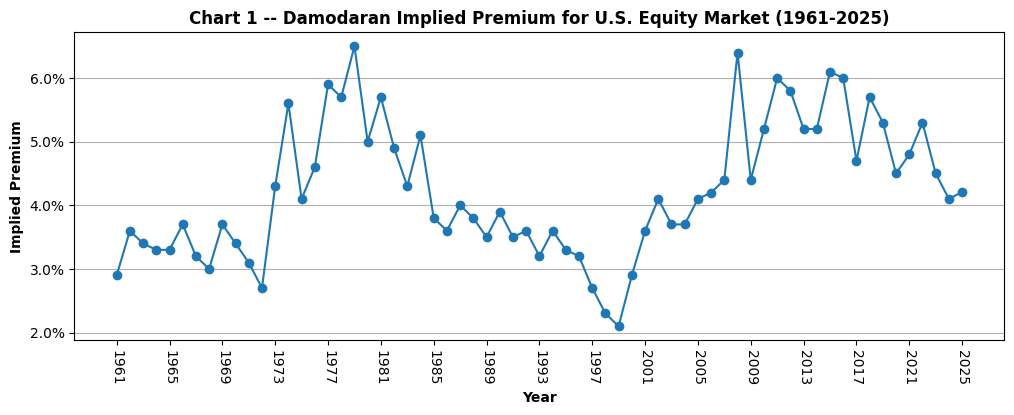

In [21]:
# Step 3 & 4: Create and Customize the Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import FixedLocator # Import FixedLocator
import pandas as pd
import numpy as np
from pathlib import Path # Import Path

fig, ax = plt.subplots(figsize=(12, 4)) # Reverted figure size to default

# Convert 'Year' to datetime objects for correct plotting and formatting
yr_df['Year_dt'] = pd.to_datetime(yr_df['Year'], format='%Y')

ax.plot(yr_df['Year_dt'], yr_df['Implied Premium'], marker='o', linestyle='-')

# Customize the plot
first_year = yr_df['Year'].min()
last_year = yr_df['Year'].max() # Get the last year from the data
ax.set_title(f'Chart 1 -- Damodaran Implied Premium for U.S. Equity Market ({first_year}-{last_year})', fontweight='bold')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Implied Premium', fontweight='bold')
ax.grid(axis='y') # Only show horizontal gridlines

# Format x-axis to show year
# Explicitly set tick locations to start at the first year and increment by 4
first_year = yr_df['Year'].min()
last_year_data = yr_df['Year'].max()
tick_years = np.arange(first_year, last_year_data + 1, 4)
tick_dates = pd.to_datetime(tick_years, format='%Y') # Convert to datetime objects
tick_locations = mdates.date2num(tick_dates) # Convert datetime objects to numerical format

ax.xaxis.set_major_locator(FixedLocator(tick_locations)) # Use FixedLocator with numerical locations
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Changed format to show full year
plt.xticks(tick_locations, rotation=270, ha='center') # Use numerical locations for plt.xticks

# Format y-axis labels as percentages with one decimal place
formatter = mticker.PercentFormatter(xmax=100.0, decimals=1) # Assuming the values are already percentages
ax.yaxis.set_major_formatter(formatter)

# Step 5: Save the Plot to a file
PLOT_DIR = Path("_plots") # Define the directory to save plots
PLOT_DIR.mkdir(exist_ok=True) # Ensure the directory exists
chart1_filename = PLOT_DIR / "chart1.png" # Define the filename for Chart 1

try:
    plt.savefig(chart1_filename, bbox_inches='tight')
    print(f"✅ Chart 1 saved to {chart1_filename}")
except Exception as e:
    print(f"Error saving chart: {e}")

# Step 6: Display the Plot
plt.show()

first run:
🔄  Cache updated.
Current  → July 2025  4.21%
Previous → June 2025  4.25%

subseq runs:
✅  Cache already current.
Current  → July 2025  4.21%
Previous → June 2025  4.25%

In [22]:
# ╔═══════════════════════════════════════════════════════════════════════╗
# Check whether Damodaran’s “Implied ERP on …” date has rolled to THIS
# month.  Works in Google Colab, no external data files required.
# ╚═══════════════════════════════════════════════════════════════════════╝
import re, requests, datetime as dt, pandas as pd
from bs4 import BeautifulSoup

# -----------------------------------------------------------------------
# SETTINGS
# -----------------------------------------------------------------------
TIMEOUT_SECS   = 30        # HTTP timeout
MAX_RETRIES    = 3         # network retries
USE_LOCAL_TZ   = True     # True → compare against your local timezone
# -----------------------------------------------------------------------

def fetch_html(url: str, retries=MAX_RETRIES):
    """Grab raw HTML with exponential back‑off."""
    for attempt in range(retries):
        try:
            return requests.get(url, timeout=TIMEOUT_SECS).text
        except Exception as e:
            if attempt == retries - 1:
                raise
            import time, math
            time.sleep(math.pow(2, attempt))  # 1s, 2s, 4s …

def parse_erp_date(html: str) -> pd.Timestamp:
    """Return the *first* `Implied ERP on <Month 1, YYYY>` date on the page."""
    soup = BeautifulSoup(html, "html.parser")
    txt  = soup.get_text(" ", strip=True)         # flatten to plain text
    match = re.search(r"Implied\s+ERP\s+on\s+([A-Za-z]+\s+\d{1,2},\s+\d{4})",
                      txt, flags=re.I)
    if not match:
        raise ValueError("Could not find 'Implied ERP on …' in page.")
    date_str = match.group(1).replace("uly", "July").replace("JJuly", "July")
    return pd.to_datetime(date_str, format="%B %d, %Y")

def site_is_current(reference_date: pd.Timestamp) -> bool:
    """True if Damodaran’s date is the same month & year as reference_date."""
    return (erp_date.year, erp_date.month) == (reference_date.year,
                                               reference_date.month)

# -----------------------------------------------------------------------
# -----------------------------------------------------------------------
url = "https://pages.stern.nyu.edu/~adamodar/New_Home_Page/home.htm"
html = fetch_html(url)
erp_date = parse_erp_date(html)

today = dt.datetime.now().astimezone() if USE_LOCAL_TZ else dt.datetime.utcnow()
today = pd.Timestamp(today.date())            # drop time of day

status = "✅  Site is up‑to‑date for this month." if site_is_current(today) \
         else "⏳  Site has NOT rolled to the new month yet."

#prev_mon
prev_month = (erp_date - pd.DateOffset(months=1)).strftime("%B %-d, %Y")

print(f"\nDamodaran page shows:  {erp_date.strftime('%B %-d, %Y')}")
print(f"Today is:               {today.strftime('%B %-d, %Y')}")
print(status)
print(f"(Expected ‘previous month’ string → {prev_month})")


Damodaran page shows:  July 1, 2025
Today is:               July 25, 2025
✅  Site is up‑to‑date for this month.
(Expected ‘previous month’ string → June 1, 2025)


In [23]:
HIST_MONTHLY = {
 (2023, 6):5.25, (2023, 7):5.00,(2023, 8):4.83,
 (2023, 9):4.90,(2023,10):4.84,(2023,11):4.88,(2023,12):4.53,
 (2024, 1):4.60,(2024, 2):4.50,(2024, 3):4.33,(2024, 4):4.23,
 (2024, 5):4.40,(2024, 6):4.27,(2024, 7):4.12,(2024, 8):4.12,
 (2024, 9):4.06,(2024,10):3.94,(2024,11):4.31,(2024,12):4.07,
 # Added values for Jan 2025 to June 2025 based on user provided data
 (2025, 1):4.33,(2025, 2):4.27,(2025, 3):4.35,(2025, 4):4.61,
 (2025, 5):4.58,(2025, 6):4.25,
}

In [24]:
# Step 1: Prepare the Data
# Convert the dictionary to a list of tuples (year, month, value)
data_list = [(year, month, value) for (year, month), value in HIST_MONTHLY.items()]

# Convert the list to a DataFrame
df_hist = pd.DataFrame(data_list, columns=['Year', 'Month', 'ERP'])

# Create a datetime index
df_hist['Date'] = pd.to_datetime(df_hist[['Year', 'Month']].assign(day=1))
df_hist = df_hist.set_index('Date')[['ERP']]

# Sort by date to ensure correct order
df_hist = df_hist.sort_index()

# Step 2: Filter the Data
# Define the end date (June 2025)
end_date = pd.Timestamp('2025-06-01')

# Define the start date (23 months prior to June 2025 is July 2023)
start_date = end_date - pd.DateOffset(months=23)

# Filter the DataFrame
filtered_df = df_hist.loc[(df_hist.index >= start_date) & (df_hist.index <= end_date)]

# Display the filtered data
display(filtered_df)

,ERP
Date,
2023-07-01,5.00
2023-08-01,4.83
2023-09-01,4.90
2023-10-01,4.84
2023-11-01,4.88
2023-12-01,4.53
2024-01-01,4.60
2024-02-01,4.50
2024-03-01,4.33


✅ Chart 2 saved to _plots/chart2.png


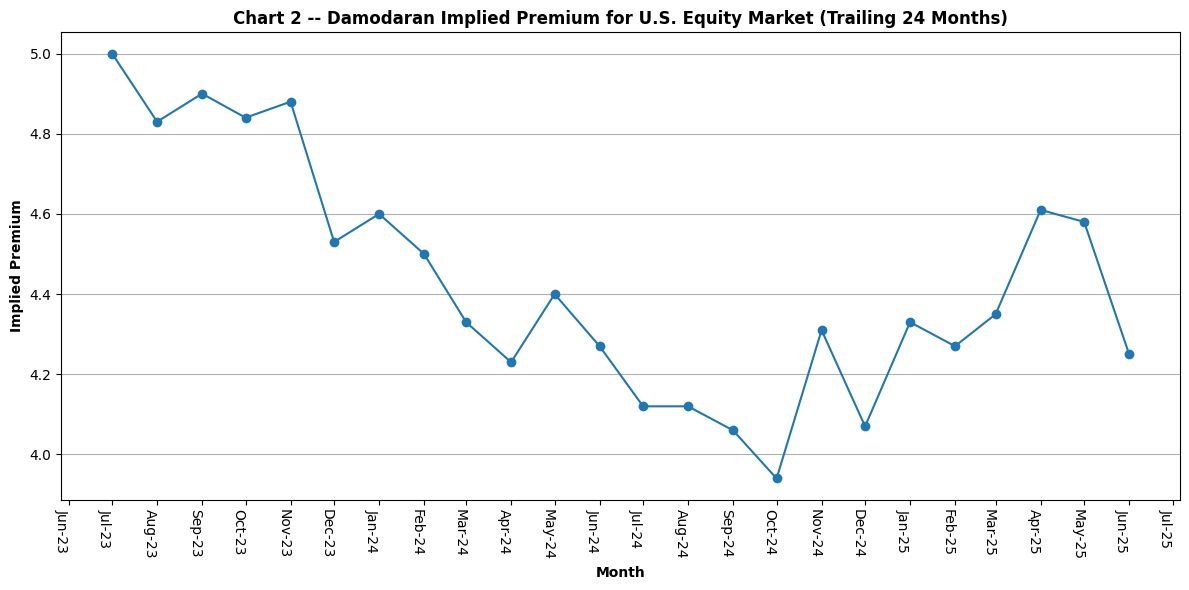

In [25]:
# Step 3 & 4: Create and Customize the Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from pathlib import Path

fig, ax = plt.subplots(figsize=(12, 6)) # Changed figure size to match Chart 1

ax.plot(filtered_df.index, filtered_df['ERP'], marker='o', linestyle='-')

# Customize the plot
ax.set_title('Chart 2 -- Damodaran Implied Premium for U.S. Equity Market (Trailing 24 Months)', fontweight='bold')
ax.set_xlabel('Month', fontweight='bold')
ax.set_ylabel('Implied Premium', fontweight='bold')
ax.grid(axis='y') # Only show horizontal gridlines

# Format x-axis to show month and year
ax.xaxis.set_major_locator(mdates.MonthLocator()) # Show a tick every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # Changed format to mmm-yr
plt.xticks(rotation=270, ha='right') # Rotate labels for better readability

# Step 5: Save the Plot
plt.tight_layout() # Adjust layout to prevent labels overlapping

chart2_filename = OUT_DIR / "chart2.png" # Define the filename for chart 2

try:
    plt.savefig(chart2_filename, bbox_inches='tight')
    print(f"✅ Chart 2 saved to {chart2_filename}")
except Exception as e:
    print(f"Error saving chart: {e}")

# Step 6: Display the Plot
plt.show()

In [26]:
from docx import Document
from docx.shared import Inches
from pathlib import Path

# Define the path to the saved chart image
#PLOT_DIR = Path("_plots")
chart1_filename = OUT_DIR / "chart1.png"

# Assuming doc1_master_test object exists from previous cells
# If not, you might need to load it:
# doc1_master_test = Document("doc1 master test.docx")

try:
    # Add the saved image to the Word document (doc1_master_test)
    doc1_master_test.add_picture(str(chart1_filename), width=Inches(6)) # Adjust width as needed
    print("✅ Chart 1 added to doc1_master_test")

    # Save the Word document
    doc1_master_test.save("doc1 master test.docx")
    print("✅ doc1 master test.docx saved with Chart 1")

except FileNotFoundError:
    print(f"Error: Chart file not found at {chart1_filename}. Please ensure the chart was saved correctly.")
except Exception as e:
    print(f"Error adding chart to document: {e}")

✅ Chart 1 added to doc1_master_test
✅ doc1 master test.docx saved with Chart 1


In [27]:
from docx import Document
from docx.shared import Inches
from pathlib import Path

# Define the path to the saved chart image
#PLOT_DIR = Path("_plots")
chart2_filename = OUT_DIR / "chart2.png"

# Assuming doc1_master_test object exists from previous cells
# If not, you might need to load it:
# doc1_master_test = Document("doc1 master test.docx")

try:
    # Add the saved image to the Word document (doc1_master_test)
    doc1_master_test.add_picture(str(chart2_filename), width=Inches(6)) # Adjust width as needed
    print("✅ Chart 2 added to doc1_master_test")

    # Save the Word document
    doc1_master_test.save("doc1 master test.docx")
    print("✅ doc1 master test.docx saved with Chart 2")

except FileNotFoundError:
    print(f"Error: Chart file not found at {chart2_filename}. Please ensure the chart was saved correctly.")
except Exception as e:
    print(f"Error adding chart to document: {e}")

✅ Chart 2 added to doc1_master_test
✅ doc1 master test.docx saved with Chart 2


In [28]:
p_ibbotson = "Another approach is used by Roger Ibbotson and Peng Chen, who annually prepare a forecast of ERP based on the contribution of earnings growth to price earnings ratio growth and on growth in per capita GDP. Their “supply side” estimate of ERP at the beginning of 2025 was about 6.26%."

doc1_master_test.add_paragraph(p_ibbotson)
doc1_master_test.save("doc1 master test.docx")

In [29]:
doc1_master_test.add_page_break()

p_table2 = "Table 2, below, compares the Ibbotson “supply side model” conclusions to the corresponding historical Kroll data for the last four “long-run” periods. Table 2 provides a summary of the historical data presented previously."

doc1_master_test.add_paragraph(p_table2)
doc1_master_test.save("doc1 master test.docx")

In [30]:
from datetime import datetime
import pytz

# Define the PST timezone
pst_timezone = pytz.timezone('America/Los_Angeles') # PST is represented by America/Los_Angeles

# Get the current date and time in PST
now_pst = datetime.now(pst_timezone)

# Print the date in a simple format
print(now_pst.date())

2025-07-25


In [31]:
from docx.oxml import OxmlElement # Import OxmlElement
from docx.oxml.ns import qn # Import qn
from docx.enum.text import WD_ALIGN_PARAGRAPH # Import WD_ALIGN_PARAGRAPH

table2_data = [
    ("99 years (1926-2024)", "6.26%", "7.31%"),
    ("98 years (1926-2023)", "6.22%", "7.17%"),
    ("97 years (1926-2022)", "6.35%", "7.17%"),
    ("96 years (1926-2021)", "6.22%", "7.46%"),
    ("95 years (1926-2020)", "6.00%", "7.25%"),
]

num_data_rows2 = len(table2_data)
total_rows2 = num_data_rows2 + 2 # 1 for title, 1 for headers

tab2 = doc1_master_test.add_table(rows=total_rows2, cols=3)
tab2.style = "Table Grid"

# Add the table title in the first row and merge cells
title_cell2 = tab2.cell(0, 0)
other_cell2 = tab2.cell(0, 1)
third_cell2 = tab2.cell(0, 2) # Get the third cell
merged_title_cell = title_cell2.merge(third_cell2) # Merge across all three columns


# Split and format the title text
merged_title_cell.text = "" # Clear existing text
run1_2 = merged_title_cell.paragraphs[0].add_run("Table 2 -- Ibbotson ")
run1_2.bold = True
run2_2 = merged_title_cell.paragraphs[0].add_run('"Supply Side"') # Changed to double quotes
run2_2.bold = True
run3_2 = merged_title_cell.paragraphs[0].add_run(" Implied ERP Estimates (arithmetic avg.)")
run3_2.bold = True


merged_title_cell.paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER # Center the title

# Add the column headers in the second row
tab2.cell(1, 0).text = "Period"
tab2.cell(1, 1).text = "Supply Side ERP"
tab2.cell(1, 2).text = "Historical ERP"

# Make headers bold
tab2.cell(1, 0).paragraphs[0].runs[0].bold = True
tab2.cell(1, 1).paragraphs[0].runs[0].bold = True
tab2.cell(1, 2).paragraphs[0].runs[0].bold = True

# Center headers
tab2.cell(1, 0).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
tab2.cell(1, 1).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
tab2.cell(1, 2).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER


# Populate the data rows (starting from the third row - index 2)
for i, r in enumerate(table2_data):
    row_index2 = i + 2
    # Unpack the tuple r and assign to the three cells in the row
    tab2.cell(row_index2, 0).text = r[0]
    tab2.cell(row_index2, 1).text = r[1]
    tab2.cell(row_index2, 2).text = r[2]

    # Center data in all columns
    tab2.cell(row_index2, 0).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
    tab2.cell(row_index2, 1).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
    tab2.cell(row_index2, 2).paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

doc1_master_test.save("doc1 master test.docx")

In [32]:
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml import OxmlElement
from docx.oxml.ns import qn

doc1_master_test.add_paragraph()

surveys_heading_para = doc1_master_test.add_paragraph()

run1 = surveys_heading_para.add_run("Surveys and ")
run1.bold = True

run2 = surveys_heading_para.add_run('"Conditional"')
run2.bold = True

run3 = surveys_heading_para.add_run(" ERP")
run3.bold = True
doc1_master_test.save("doc1 master test.docx")
print("✅ Added 'Surveys and \"Conditional\" ERP' heading and saved doc.")

✅ Added 'Surveys and "Conditional" ERP' heading and saved doc.


In [33]:
##############################################

p_surveys_desc = doc1_master_test.add_paragraph()
surveys_text_parts = [
    "In ",
    ("Cost of Capital, ", True),
    "5", # Separate the number 5
    ("th", True, "superscript"), # Add "th" as a separate part with superscript instruction
    " ed. (Hoboken: John Wiley & Sons, 2014), Shannon Pratt and Roger Grabowski report that research has shown the ERP varies with the business cycle. They use the term ",
    ("conditional", True),
    " ERP to mean the ERP that reflects current market conditions. For example, when the economy is near or in recession, the ",
    ("conditional", True),
    " ERP is more likely at the higher end of the range, and when the economy is near its peak, the ",
    ("conditional", True),
    " ERP is more likely at the lower end of the range. This variability in the ERP is particularly evident in Chart 1 and Chart 3."
]

for part in surveys_text_parts:
    if isinstance(part, tuple):
        run = p_surveys_desc.add_run(part[0])
        run.font.italic = part[1]
        if len(part) > 2 and part[2] == "superscript":
            run.font.superscript = True
    else:
        p_surveys_desc.add_run(part)

p_surveys_desc2 = doc1_master_test.add_paragraph()
surveys_text_parts2 = [
    "While the ",
    ("unconditional", True),
    ", or long-term average, ERP is generally considered by practitioners to be most appropriate for business valuation purposes, the TSC should recognize the significant variability in expected returns over the business cycle and consider current expectations when making its ongoing determination of ERP."
]

for part in surveys_text_parts2:
    if isinstance(part, tuple):
        run = p_surveys_desc2.add_run(part[0])
        run.font.italic = part[1]
    else:
        p_surveys_desc2.add_run(part)

doc1_master_test.save("doc1 master test.docx")
print("✅ Added 'Surveys and \"Conditional\" ERP' desc + saved doc.")

' ERP is more likely at the lower end of the range. This variability in the ERP is particularly evident in Chart 1 and Chart 3.'

In [34]:
bond_data_LT = doc1_master_test.add_paragraph()

bond_run = bond_data_LT.add_run("Long-term Bond Data")
bond_run.bold = True

doc1_master_test.add_paragraph("Chart 3 below shows the historical yield on the 20-Year Treasury Bond.")

doc1_master_test.save("doc1 master test.docx")
print("✅ Added 'Surveys and \"Conditional\" ERP' heading and saved doc.")

✅ Added 'Surveys and "Conditional" ERP' heading and saved doc.


In [35]:
# ─────────────────────── 1.  Helper functions ────────────────────
def fetch_ust_yield_data(start_year: int,
                         end_year: int,
                         yield_tag: str = "d:BC_20YEAR") -> pd.DataFrame:
    """Scrape XML pages year-by-year and return DF(Date, Yield)."""
    data = {"Date": [], "Yield": []}

    for yr in range(start_year, end_year + 1):
        url = ("https://home.treasury.gov/resource-center/data-chart-center/"
               f"interest-rates/pages/xmlview?data=daily_treasury_yield_curve"
               f"&field_tdr_date_value={yr}")
        try:
            soup = BeautifulSoup(requests.get(url, timeout=30).text, "xml")
            dates  = soup.find_all("d:NEW_DATE")
            yields = soup.find_all(yield_tag)
            if len(dates) != len(yields):
                print(f"⚠️  {yr}: {len(dates)} dates vs {len(yields)} yields")

            for d_tag, y_tag in zip(dates, yields):
                try:
                    data["Date"].append(pd.to_datetime(d_tag.get_text()))
                    data["Yield"].append(float(y_tag.get_text()))
                except ValueError:
                    continue

        except requests.exceptions.RequestException as exc:
            print(f"✖  {yr} failed: {exc}")

    df = (pd.DataFrame(data)
            .dropna(subset=["Yield"])
            .sort_values("Date")
            .reset_index(drop=True))
    return df

#########################################################################


⚠️  2010: 252 dates vs 251 yields
✅ Chart 3 saved to _plots/chart3.png


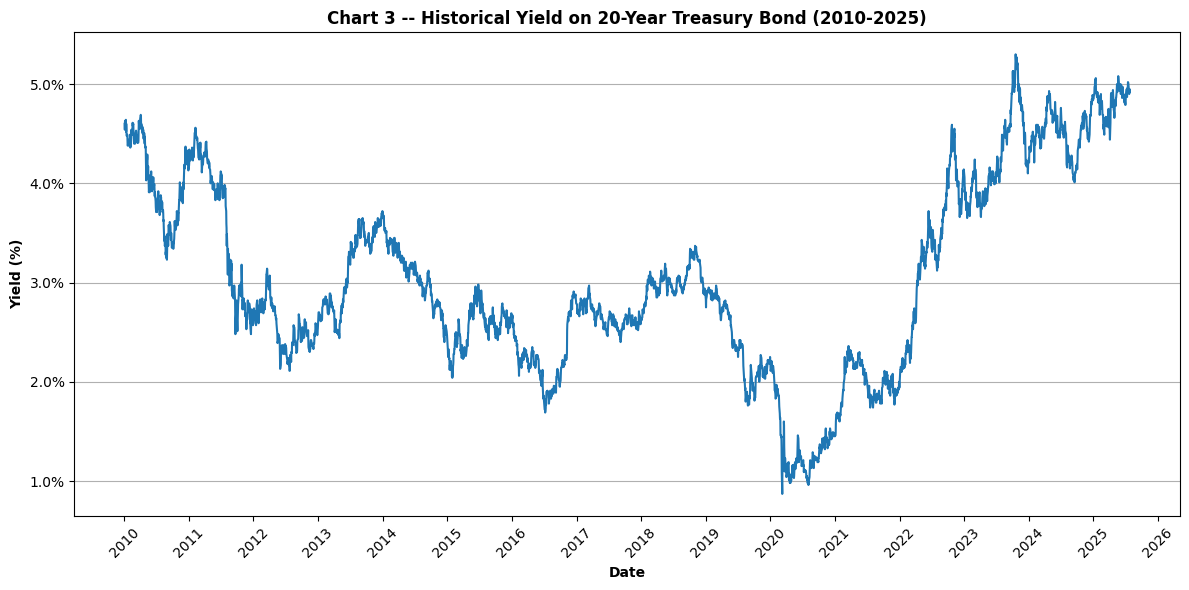

✅ Chart 3 added to doc1_master_test with adjusted width
✅ doc1 master test.docx saved with Chart 3


In [36]:
# Step 1: Fetch the data
start_year = 2010 # Starting year for 20-Year Treasury Yield data
end_year = 2025   # Ending year

ust_yield_df = fetch_ust_yield_data(start_year, end_year)

# Step 2 & 3: Create and Customize the Plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from pathlib import Path # Import Path for path handling
from docx.shared import Inches # Import Inches for adding picture
from docx.shared import Emu # Import Emu for calculations
from docx.shared import Twips # Import Twips for calculations # Keep Twips import if needed elsewhere


fig, ax = plt.subplots(figsize=(12, 6)) # This figure size affects the plot's aspect ratio before saving

ax.plot(ust_yield_df['Date'], ust_yield_df['Yield'], linestyle='-')

# Customize the plot
ax.set_title(f'Chart 3 -- Historical Yield on 20-Year Treasury Bond ({start_year}-{end_year})', fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Yield (%)', fontweight='bold') # Label Y-axis as Yield (%)
ax.grid(axis='y') # Only show horizontal gridlines

# Format x-axis to show year
ax.xaxis.set_major_locator(mdates.YearLocator(1)) # Show a tick every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Changed format to show full year
plt.xticks(rotation=45, ha='center') # Rotate labels for better readability and center them

# Format y-axis labels as percentages with one decimal place
formatter = mticker.PercentFormatter(xmax=100.0, decimals=1) # Assuming the values are already percentages
ax.yaxis.set_major_formatter(formatter)


# Step 4: Save the Plot to a file
PLOT_DIR = Path("_plots") # Define the directory to save plots
PLOT_DIR.mkdir(exist_ok=True) # Ensure the directory exists
chart3_filename = PLOT_DIR / "chart3.png" # Define the filename for Chart 3

try:
    # It's better to save the figure using the fig object
    fig.savefig(chart3_filename, bbox_inches='tight')
    print(f"✅ Chart 3 saved to {chart3_filename}")
except Exception as e:
    print(f"Error saving chart: {e}")


# Step 5: Display the Plot
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# Step 6: Add Chart 3 to the Word document and save
try:
    # Assuming doc1_master_test object exists from previous cells
    # Access the section to get page width and margins
    section = doc1_master_test.sections[0]

    # Calculate usable width in EMU and convert to Inches
    usable_width_emu = section.page_width - section.left_margin - section.right_margin
    # 914400 EMU = 1 inch
    usable_width_inches = usable_width_emu / 914400.0


    # Add the saved image to the Word document (doc1_master_test)
    # Use the calculated usable width in Inches
    doc1_master_test.add_picture(str(chart3_filename), width=Inches(usable_width_inches))
    print("✅ Chart 3 added to doc1_master_test with adjusted width")

    doc1_master_test.save("doc1 master test.docx") # Save the document
    print("✅ doc1 master test.docx saved with Chart 3")

except Exception as e:
    print(f"Error adding chart 3 to document: {e}")